In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import matplotlib.cm as cm

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *

import sys
sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

import backtest
import statsmodels.formula.api as smf
import statsmodels.api
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
import matplotlib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (15, 12)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [15]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm', ]
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR',] #   
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss'] # , 
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'PF', 'fu', 'eg', 'eb', 'lu', 'pg',] #   
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'lh', 'PK', 'CY', 'sp', 'CJ',] #  
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC', 'IM']
bond_fut_mkts = ['T', 'TF', 'TS']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


# loading data and take log return

In [16]:
field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

factor_list = ['lrstd','upstd','lrskew','lrkurt','mincnt','volmf','oimf','trdstr','volmfratio']

shared_cols = ['date', 'split_idx']

rev_char = '!'
atr_win = 20
file_folder = "C:\\dev\\data\\data_cache\\"


start_date = datetime.date(2015,1,1)
end_date = datetime.date(2023,1,20)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = ind_all_mkts + ags_all_mkts
nb_cont = 1
freq='d1'


data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        print("loading product = %s nb = %s" % (prodcode, nb))
        xdf = dataseries.nearby(prodcode,
                                  nb+1,
                                  start_date=start_date, 
                                  end_date=end_date, 
                                  shift_mode=shift_mode,
                                  freq=freq, 
                                  roll_name=roll_name, 
                                  config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)

xdata = df.loc[:,(df.columns.get_level_values(2) == 'close') 
               & (df.columns.get_level_values(1) == 'c1')].droplevel([1,2], axis=1)
logret = np.log(xdata).diff()
logret

print(df.tail(20), logret.tail(20))

loading product = rb nb = 0
loading product = hc nb = 0
loading product = i nb = 0
loading product = j nb = 0
loading product = jm nb = 0
loading product = ru nb = 0
loading product = FG nb = 0
loading product = SM nb = 0
loading product = SF nb = 0
loading product = nr nb = 0
loading product = SA nb = 0
loading product = UR nb = 0
loading product = cu nb = 0
loading product = al nb = 0
loading product = zn nb = 0
loading product = pb nb = 0
loading product = ni nb = 0
loading product = sn nb = 0
loading product = ss nb = 0
loading product = l nb = 0
loading product = pp nb = 0
loading product = v nb = 0
loading product = TA nb = 0
loading product = MA nb = 0
loading product = bu nb = 0
loading product = sc nb = 0
loading product = PF nb = 0
loading product = fu nb = 0
loading product = eg nb = 0
loading product = eb nb = 0
loading product = lu nb = 0
loading product = pg nb = 0
loading product = m nb = 0
loading product = RM nb = 0
loading product = y nb = 0
loading product = p nb = 0

# PCA analysis

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

col_list = ind_all_mkts
n_pca = 10

start_d = pd.to_datetime('2016-01-01')
end_d = pd.to_datetime('2023-01-20')

selected_logret = logret[(logret.index >= start_d) & (logret.index<=end_d)]
selected_logret = selected_logret[col_list].dropna()
print(selected_logret.head(10))
x_std = StandardScaler().fit_transform(selected_logret)

pca = PCA(n_components=n_pca)
pca.fit(x_std)
explained_ratio = pca.explained_variance_ratio_

product           rb        hc         i         j        jm        ru  \
date                                                                     
2018-03-28 -0.004969 -0.002233 -0.012465 -0.035664 -0.016110 -0.008989   
2018-03-29  0.023690  0.014425  0.005685  0.001125  0.015710  0.002181   
2018-03-30  0.030541  0.025827  0.005653  0.024164  0.024088  0.014277   
2018-04-02 -0.013957 -0.003764  0.006742  0.014169 -0.000390 -0.005600   
2018-04-03  0.002986 -0.003779 -0.012395  0.013170  0.004284 -0.012606   
2018-04-04 -0.010791  0.004048 -0.039133  0.008773  0.010823 -0.007905   
2018-04-09  0.026763  0.027099  0.012465 -0.006373 -0.007332  0.009653   
2018-04-10  0.003223  0.004257  0.015643 -0.000266 -0.005048  0.011290   
2018-04-11 -0.007044 -0.014836 -0.007791 -0.024057 -0.015693 -0.008673   
2018-04-12  0.002060  0.008871  0.005571 -0.008053 -0.021989  0.000000   

product           FG        SM        SF        cu        al        zn  \
date                                 

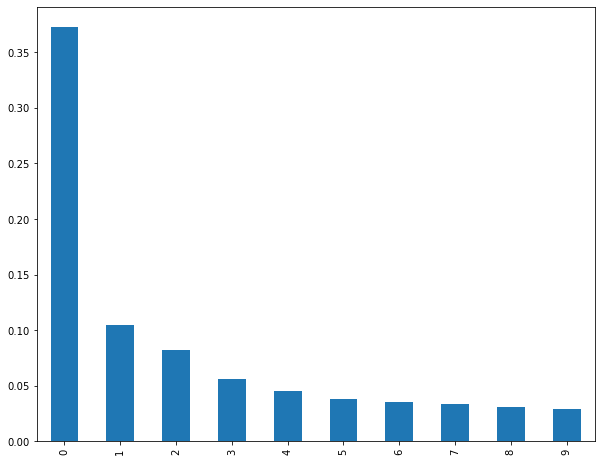

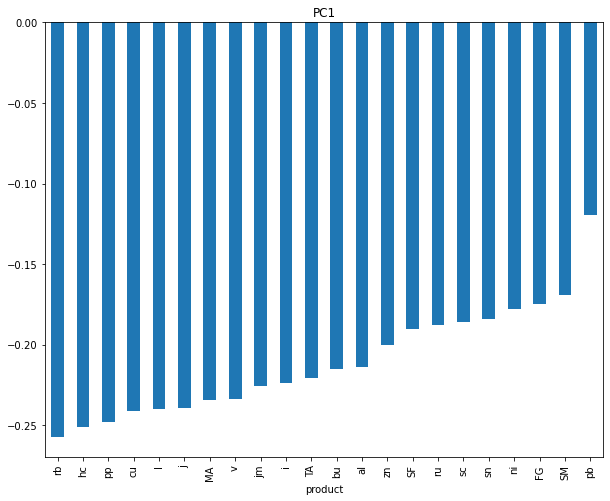

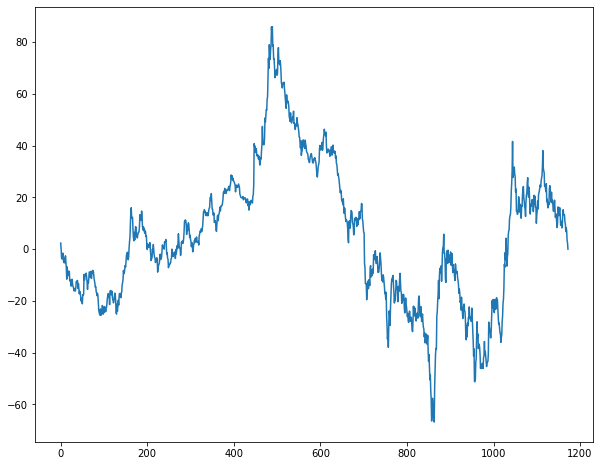

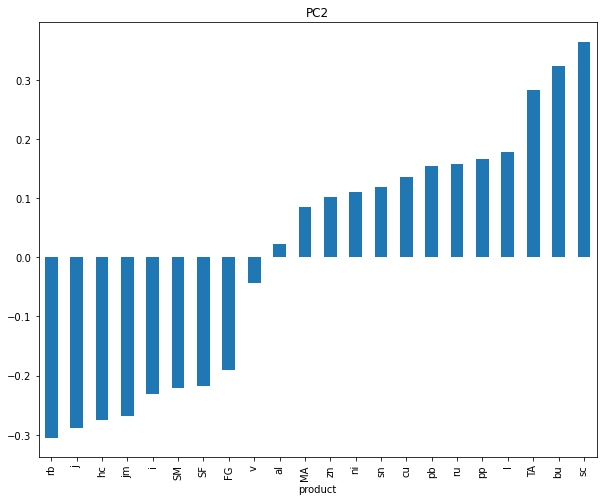

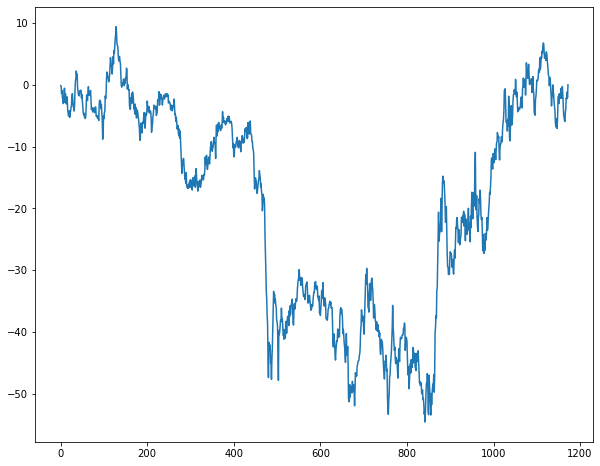

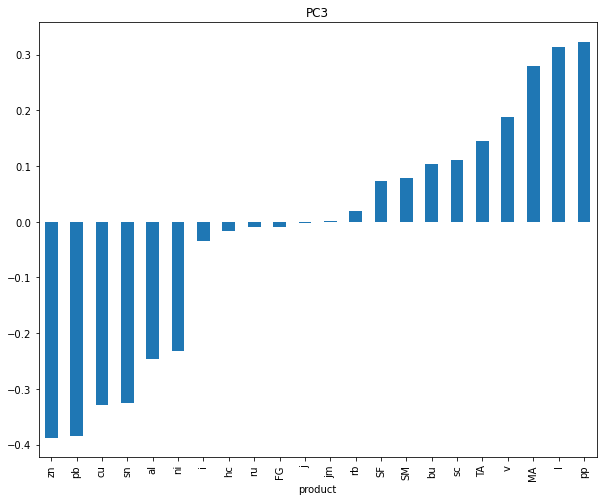

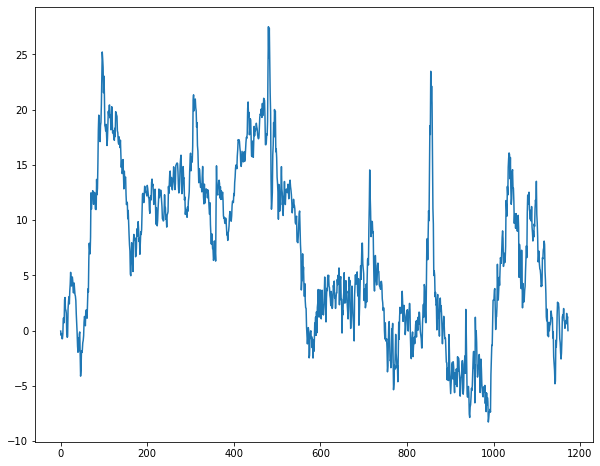

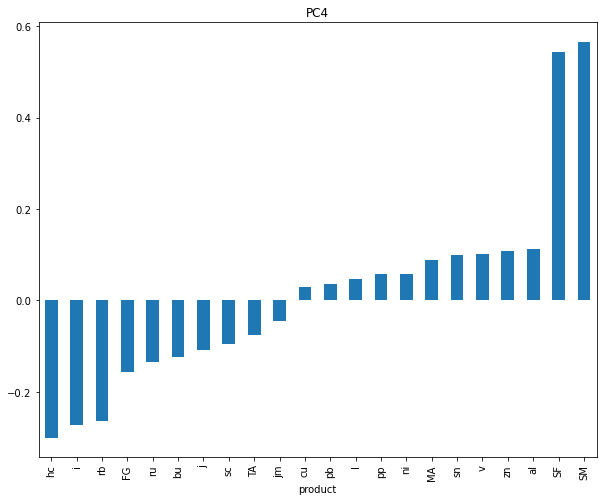

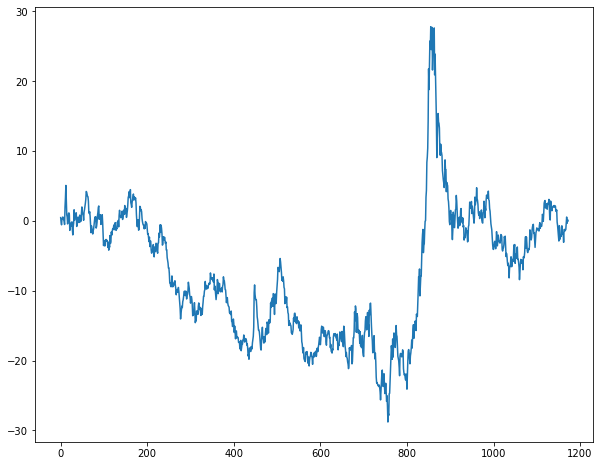

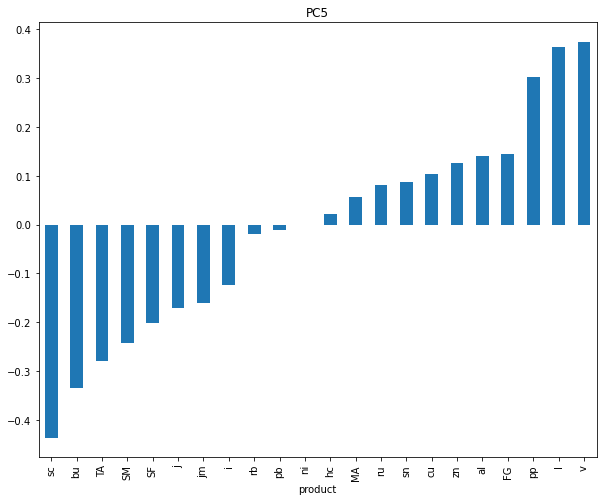

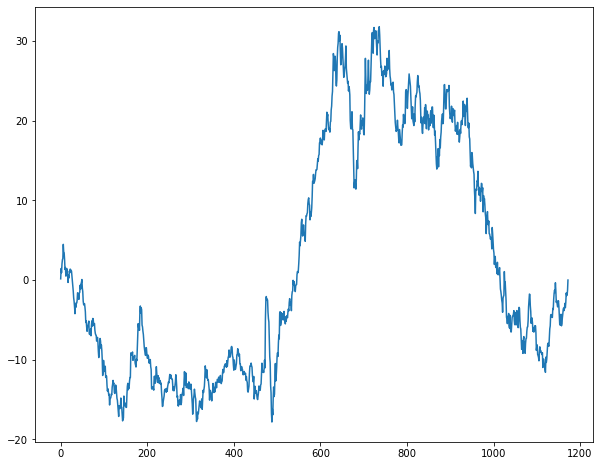

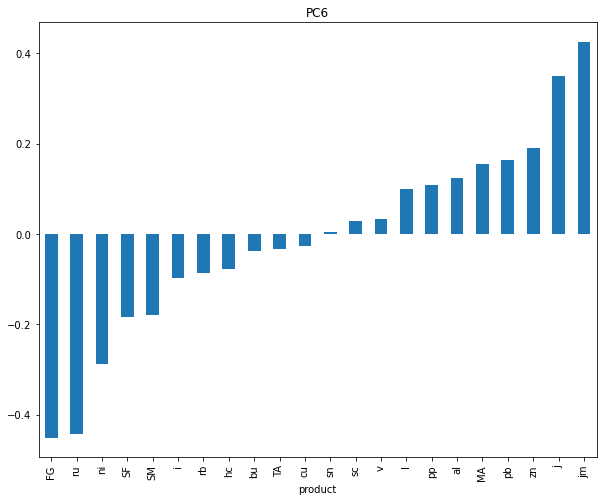

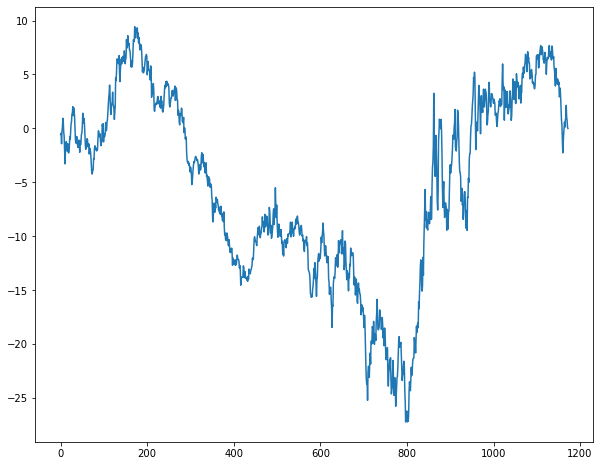

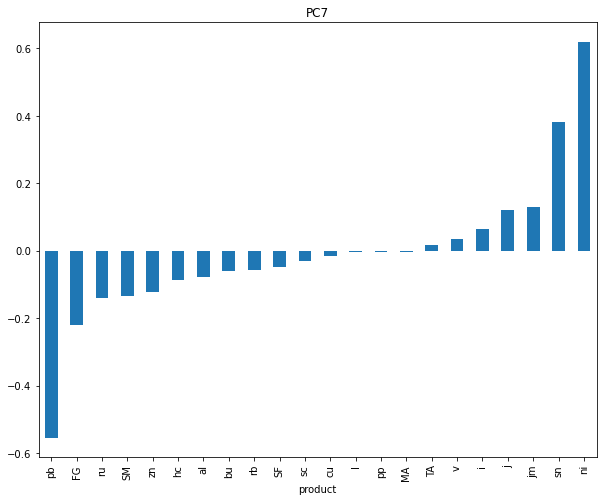

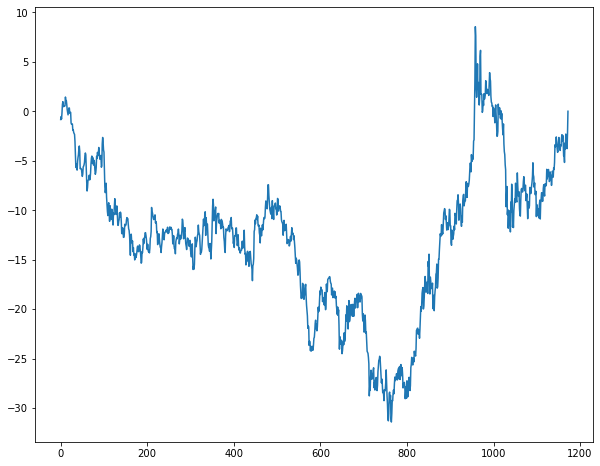

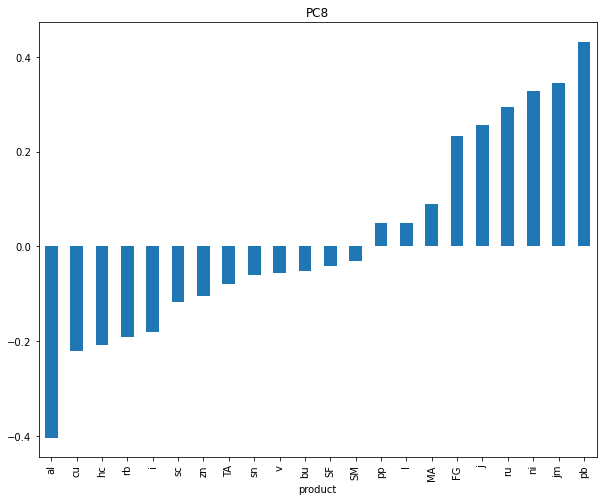

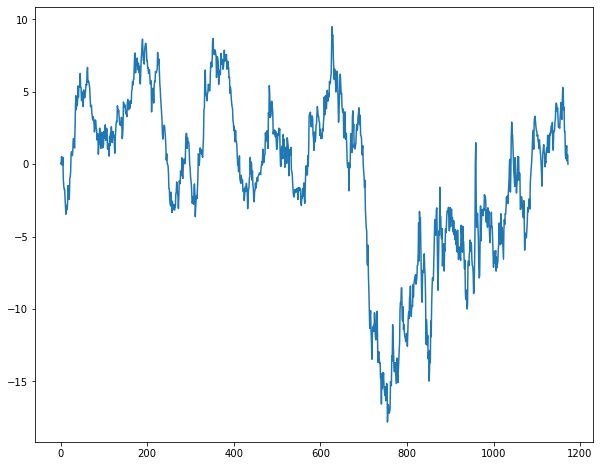

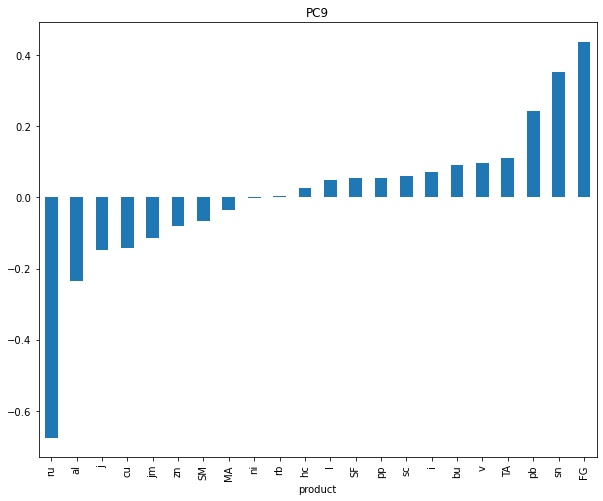

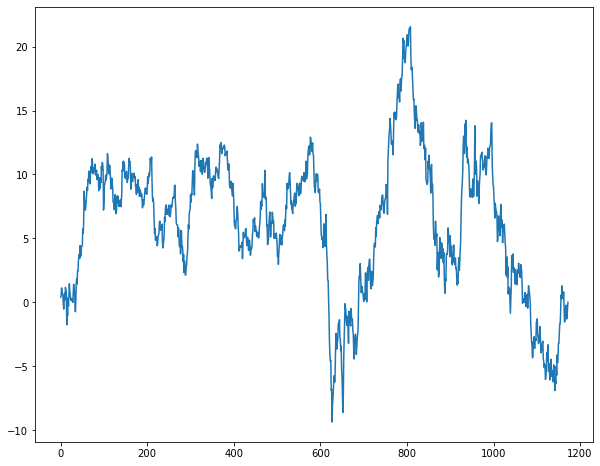

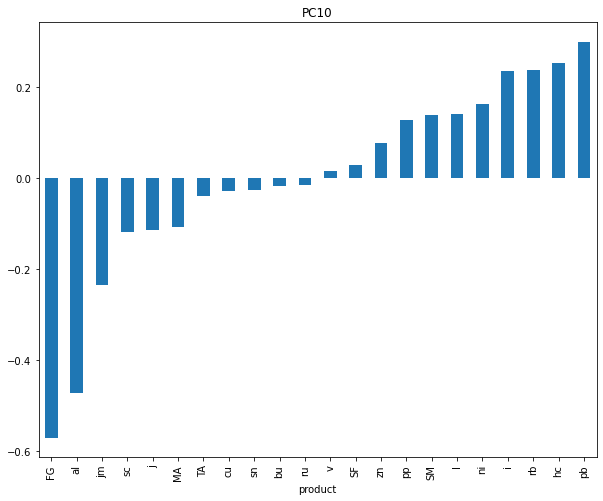

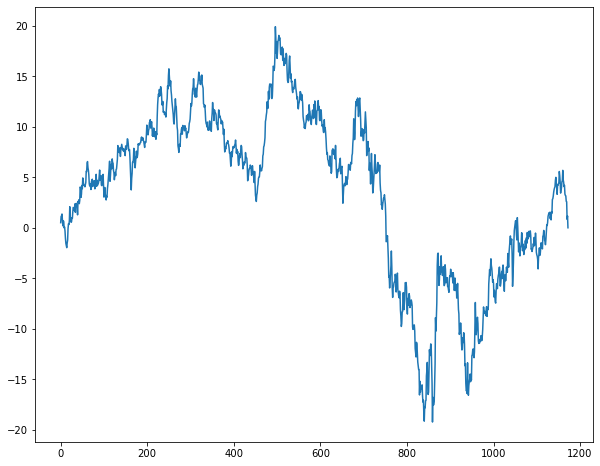

(PCA(n_components=10),
 {0: 0       2.346666
  1      -2.249907
  2      -3.541895
  3      -0.362612
  4       1.189212
            ...   
  1168    1.504345
  1169   -1.190483
  1170   -3.694205
  1171   -0.966896
  1172   -2.404684
  Length: 1173, dtype: float64,
  1: 0      -0.147772
  1      -0.068902
  2      -1.194077
  3       0.455997
  4      -1.194341
            ...   
  1168    1.818038
  1169   -0.226339
  1170    1.169103
  1171   -0.913261
  1172    2.083112
  Length: 1173, dtype: float64,
  2: 0      -0.044603
  1      -0.381195
  2       0.156806
  3      -0.459820
  4      -0.008321
            ...   
  1168   -0.288511
  1169    0.932887
  1170   -0.645272
  1171    0.347841
  1172   -1.258723
  Length: 1173, dtype: float64,
  3: 0       0.477898
  1      -0.684275
  2      -0.349568
  3       0.844671
  4       0.087289
            ...   
  1168    1.005185
  1169    0.776311
  1170   -0.891291
  1171    0.520135
  1172   -0.186798
  Length: 1173, dtype: float64,
 

In [10]:
matplotlib.rcParams['figure.figsize'] = (10, 8)

def plot_pca(data_df, n_pca = 10):
    x_std = StandardScaler().fit_transform(data_df)
    pca = PCA(n_components=n_pca)
    pca.fit(x_std)
    pd.Series(pca.explained_variance_ratio_).plot.bar()
    plt.show()
    product_list = data_df.columns
    eigen_port = {}
    for n in range(n_pca):
        ax = pd.Series(pca.components_[n], index=data_df.columns).sort_values().plot.bar()
        ax.set_title(f'PC{n+1}')
        plt.show()
        eigen_port[n] = pd.Series(np.dot(x_std, pca.components_[n]))
        eigen_port[n].cumsum().plot()
        plt.show()
    return pca, eigen_port

plot_pca(selected_logret)

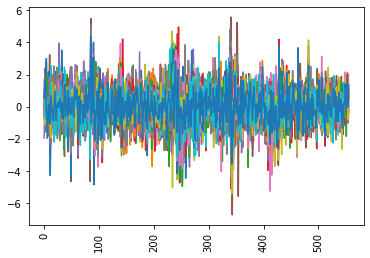

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

#A messy plot of all the processed adjusted closing prices
%matplotlib inline
plt.plot(x_std);
plt.xticks(rotation='vertical');

# Clustering  

In [37]:
col_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', 'ni', \
               'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
               'AP', 'SM', 'SF', 'eb', 'eg', 'UR', 'CJ', 'SR', 'sp', 'PK']

n_pca = 10

start_d = pd.to_datetime('2015-01-01')
end_d = pd.to_datetime('2023-01-20')

selected_lr = logret[(logret.index >= start_d) & (logret.index<=end_d)]
selected_lr = selected_lr[col_list].dropna()
print(selected_lr.head(10))


product           rb        hc         i         j        jm        ru  \
date                                                                     
2021-02-03  0.005043  0.006480  0.015414  0.006441 -0.008910 -0.018705   
2021-02-04  0.016863  0.011924  0.044360  0.023792  0.038492  0.021789   
2021-02-05  0.009143  0.014258  0.013531 -0.000392  0.002316  0.007838   
2021-02-08  0.011601  0.021344  0.023125  0.018641  0.009865  0.002373   
2021-02-09  0.019418  0.015281  0.032068  0.009764  0.016551  0.006077   
2021-02-10 -0.003626 -0.001735  0.009377 -0.011304 -0.004193 -0.011850   
2021-02-18  0.027988  0.021469  0.054485  0.062369  0.038984  0.035138   
2021-02-19 -0.001105 -0.003831 -0.012898 -0.018453 -0.025820  0.028847   
2021-02-22  0.012739  0.027756  0.019504 -0.035473 -0.040689  0.012067   
2021-02-23 -0.006569 -0.004781 -0.028497 -0.016568 -0.029330  0.011300   

product           FG        cu        al        zn        pb        sn  \
date                                 

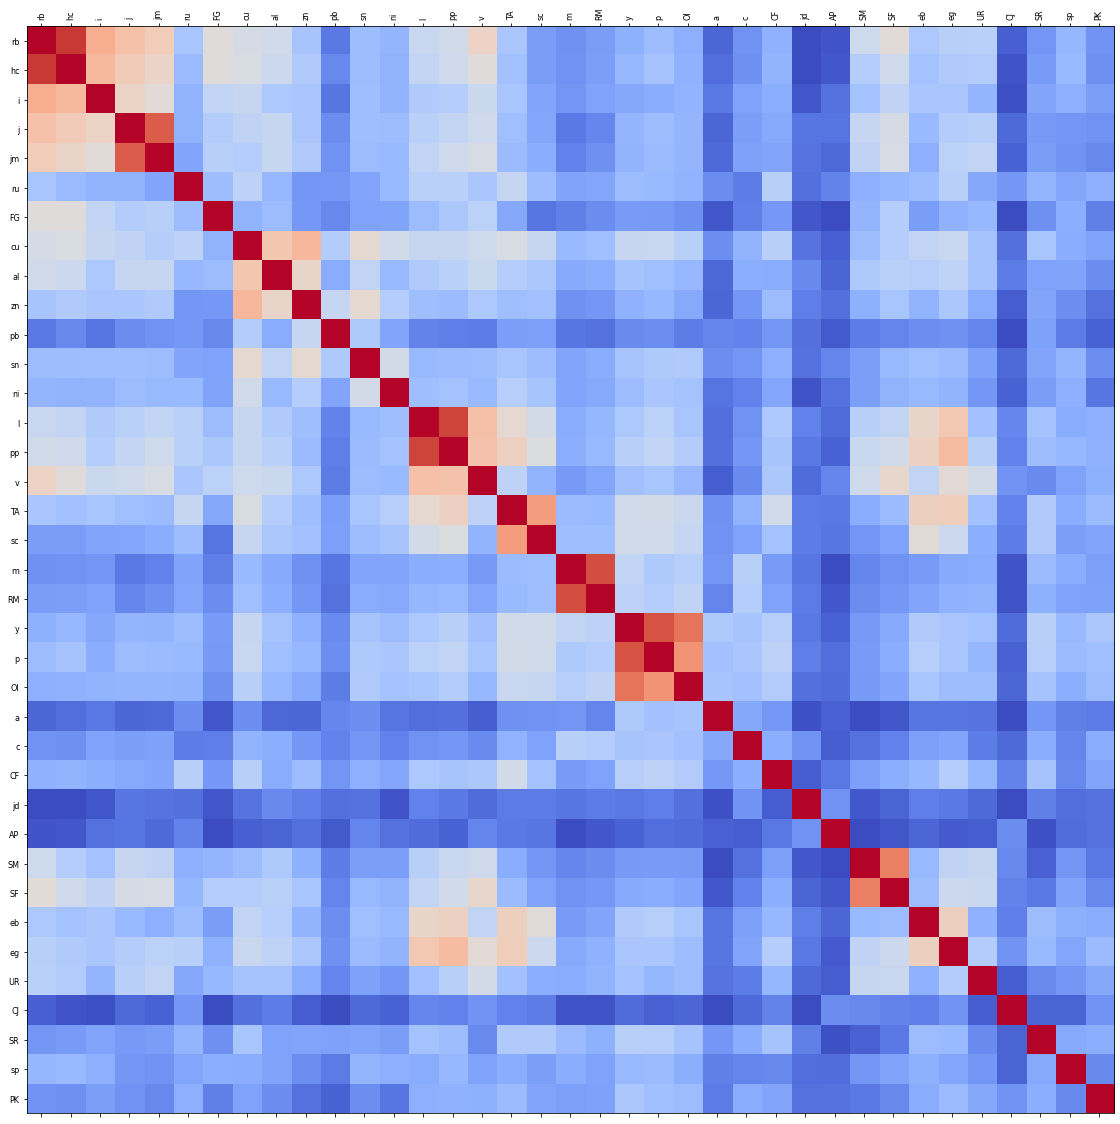

In [38]:
corr = selected_lr.corr()
size = 20
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8);

In [39]:
import scipy.cluster.hierarchy as sch 
from scipy.spatial.distance import pdist
import pylab

Z = sch.linkage(corr, 'average')
print(Z[0])

c, coph_dists = sch.cophenet(Z, pdist(corr))
print(c)

[0.         1.         0.18504785 2.        ]
0.8311153173952429


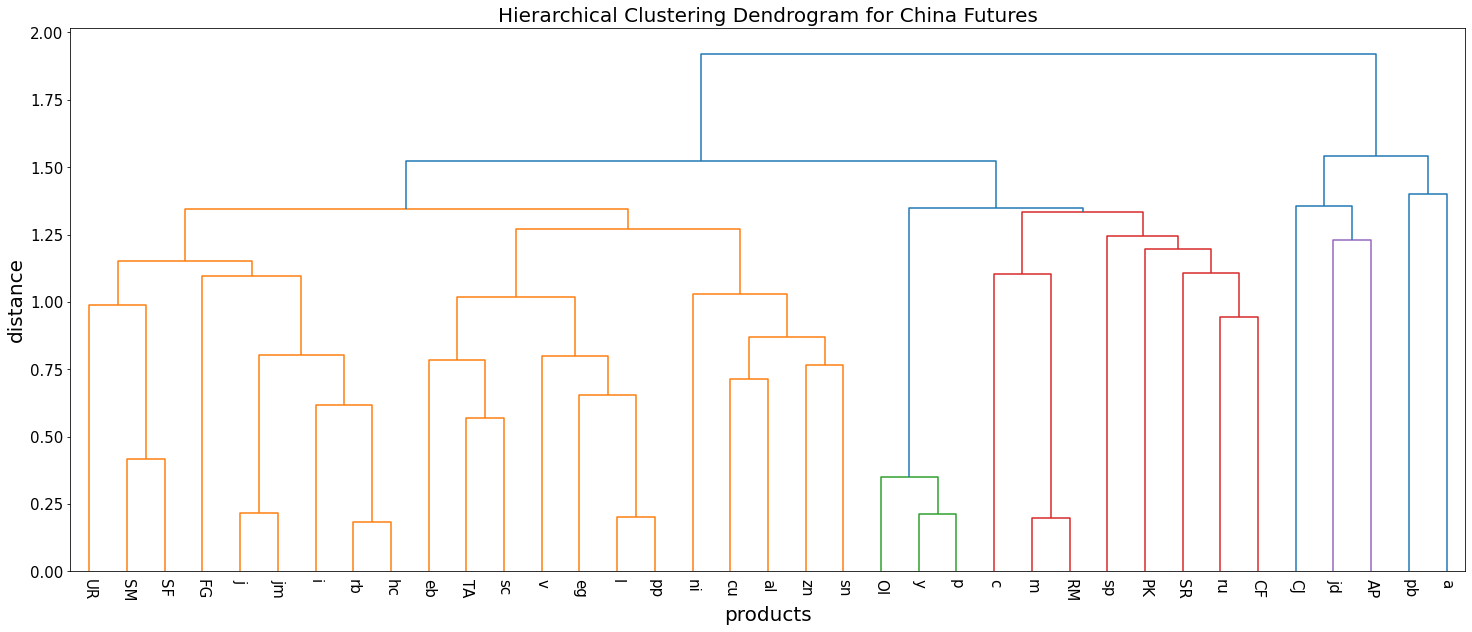

In [40]:
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram for China Futures', fontsize=labelsize)
plt.xlabel('products', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
sch.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.savefig('dendogram_'+'china_fut'+'.png')
plt.show()

In [56]:
from scipy.cluster import hierarchy as sch
d = sch.distance.pdist(corr)
L = sch.linkage(d, method="average")
cutoff = 1.4
ind = sch.fcluster(L, cutoff, "distance")
pd.Series(ind, index=selected_lr.columns)


product
rb    5
hc    5
i     5
j     5
jm    5
ru    6
FG    5
cu    6
al    6
zn    6
pb    3
sn    6
ni    6
l     6
pp    6
v     6
TA    6
sc    6
m     4
RM    4
y     4
p     4
OI    4
a     1
c     1
CF    6
jd    2
AP    2
SM    5
SF    5
eb    6
eg    6
UR    5
CJ    2
ss    6
pg    6
lu    6
fu    6
SR    6
b     4
cs    1
dtype: int32

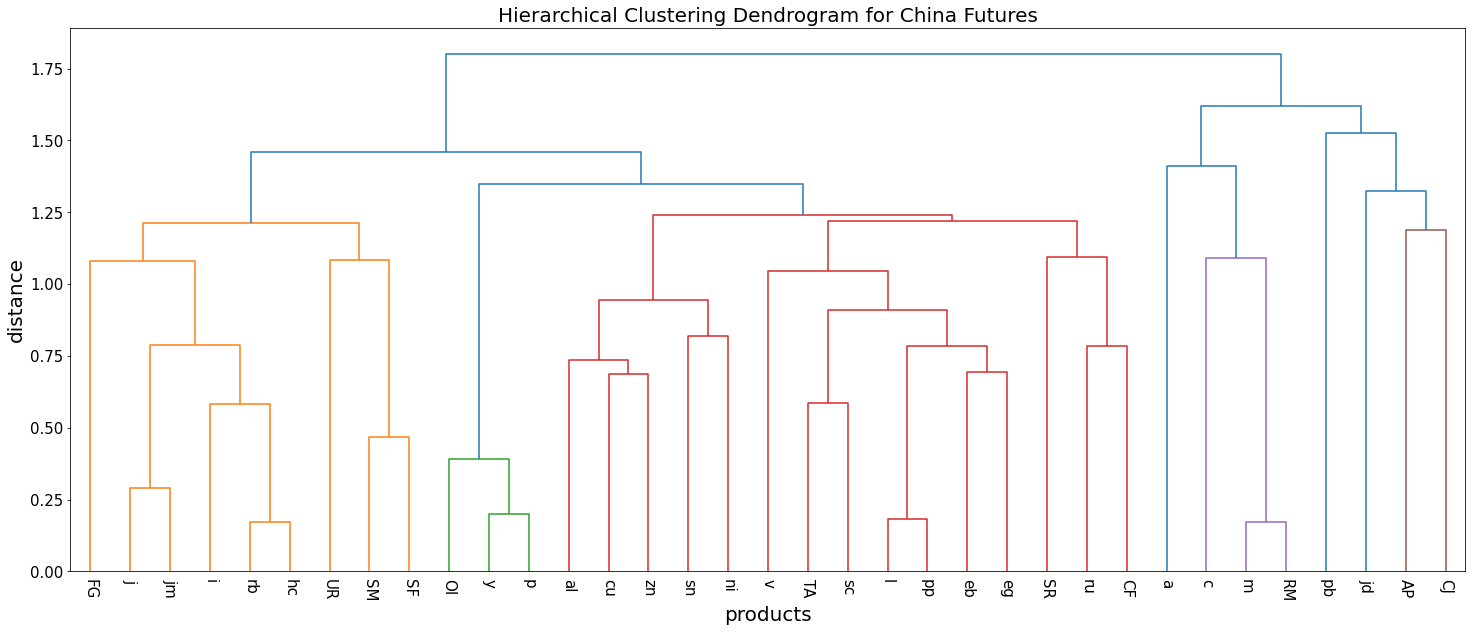

product
rb    1
hc    1
i     1
j     1
jm    1
ru    1
FG    1
cu    1
al    1
zn    1
pb    4
sn    1
ni    1
l     1
pp    1
v     1
TA    1
sc    1
m     2
RM    2
y     1
p     1
OI    1
a     2
c     2
CF    1
jd    3
AP    3
SM    1
SF    1
eb    1
eg    1
UR    1
CJ    3
SR    1
dtype: int32

In [36]:
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram for China Futures', fontsize=labelsize)
plt.xlabel('products', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)


distance_matrix = sch.linkage(sch.distance.pdist(corr), method='average')
dn = sch.dendrogram(distance_matrix,
                    leaf_rotation=90.,  # rotates the x axis labels
                    leaf_font_size=8.,  # font size for the x axis labels
                    labels=corr.columns)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)

plt.show()

threshold = 1.5
labels = sch.fcluster(distance_matrix, threshold, criterion='distance')
pd.Series(labels, index=selected_lr.columns)